### Notebook example for building a BrevisNet model using Inceptionv3 as a base.

Things to keep in mind when running this example: 
1. That the dataset size matches the model input size
2. That the names of the joining layer points matches what you expect
3. That your computer has enough memory to build the model and train as well as shuffle and load the dataset. In testing I've found that if the kernel gets interupted and then continued, the ram and gpu memory allocation can get wonky when performing the fit command.

---


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append("..") # Adds higher directory to python modules path.
import branchingdnn as branching

ModuleNotFoundError: No module named 'branchingdnn'

In [ ]:
# (train_ds, test_ds, validation_ds) = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(227,227),include_targets=True)

In [ ]:
def calcEntropy(y_hat):
        #entropy is the sum of y * log(y) for all possible labels.
        if isinstance(y_hat, list):
            y_hat = np.array(y_hat)
        sum_entropy = 0
        if y_hat.ndim >1:
            return list(map(calcEntropy,y_hat))
        for i in range(len(y_hat)):
            if y_hat[i] != 0: # log of zero is undefined, see MacKay's book "Information Theory, Inference, and Learning Algorithms"  for more info on this workaround reasoning.
                entropy =y_hat[i] * math.log(y_hat[i],2)
                sum_entropy +=  entropy

        return -sum_entropy
    
def calcEntropy_Tensors(y_hat):
        #entropy is the sum of y * log(y) for all possible labels.
        #doesn't deal with cases of log(0)
        rank = tf.rank(y_hat)
        def calc_E(y_hat):
            results = tf.clip_by_value((tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))), -1e12, 1e12)
#             results = tf.clip_by_value(results, -1e12, 1e12)
#             print("res ", results)
            return tf.reduce_sum(y_hat * results)

        sumEntropies = (tf.map_fn(calc_E,tf.cast(y_hat,'float')))
        
        if rank == 1:
            sumEntropies = tf.reduce_sum(sumEntropies)
        return -sumEntropies
    
def calcEntropy_Tensors2(y_hat):
    #entropy is the sum of y * log(y) for all possible labels.
    #doesn't deal with cases of log(0)
#     num = tf.math.log(y_hat)
# #     print("num",num)
#     dem = tf.math.log(tf.constant(2, dtype=y_hat.dtype))
# #     print("dem",dem)
#     E = num / dem
# #     print("E",E)
#     P = y_hat * E
# #     print("p",P)
#     mean = tf.reduce_mean(tf.boolean_mask(P, tf.math.is_finite(P)))
#     print("mean",mean)
#     sumEntropies = mean
    val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
    sumEntropies =  tf.reduce_mean(tf.boolean_mask(val,tf.math.is_finite(val)))
    return -sumEntropies
    
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)

def KL(alpha):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)

    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)

    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl

In [ ]:
class CrossEntropyEndpoint(tf.keras.layers.Layer):
        def __init__(self, num_outputs, name=None, **kwargs):
            super(CrossEntropyEndpoint, self).__init__(name=name)
            self.num_outputs = num_outputs
#             self.kl = tf.keras.losses.KLDivergence()
            self.loss_fn = tf.keras.losses.CategoricalCrossentropy()
#             self.loss_fn = tf.keras.losses.categorical_crossentropy
            self.evidence = softplus_evidence
#             self.evidence = tf.compat.v1.distributions.Dirichlet
            self.temperature = 10
            self.lmb = 0.005
        def build(self, input_shape):
            self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])
        
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'num_outputs': self.num_outputs,
                'name': self.name
            })
            return config

        def call(self, inputs, labels,learning_rate=1):
            outputs = tf.matmul(inputs,self.kernel)
            softmax = tf.nn.softmax(outputs)
            evidence = self.evidence (outputs)
            alpha = evidence + 1
            u = self.num_outputs / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
          
            # prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
            pred = tf.argmax(outputs,1)
            truth = tf.argmax(labels,1)
            match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
            # total_evidence = tf.reduce_sum(evidence,1, keepdims=True)
            mean_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
            mean_fail = tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) )
            
            self.add_metric(evidence, name=self.name+"_evidence",aggregation='mean')
            self.add_metric(mean_succ, name=self.name+"_mean_ev_succ",aggregation='mean')
            self.add_metric(mean_fail, name=self.name+"_mean_ev_fail",aggregation='mean')
            
            return outputs

In [ ]:
def loss_function(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay

    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = softplus_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        C =  annealing_coef * KL(alp)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C

    return  cross_entropy_evidence

In [6]:
K = 10
def loss_function(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = softplus_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_coef * KL(alp)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C
    return  cross_entropy_evidence

# outputs =[]
# targets = tf.keras.Input(shape=(10,),name='targets')
# inputs = tf.keras.Input(shape=(227,227,3))
# x = tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(inputs)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),padding="same")(x)


# branchLayer = tf.keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(x)
# branchLayer = tf.keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
# branchLayer = tf.keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
# # branchLayer = tf.keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_output"))(branchLayer)
# # branch_output_1 = (CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer,targets))
# branch_output_1 = tf.keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer)

# x = tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),padding="same")(x)


# branchLayer = tf.keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(x)
# branchLayer = tf.keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
# branchLayer = tf.keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
# # branchLayer = tf.keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_output"))(branchLayer)
# # branch_output_2 = (CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer,targets))
# branch_output_2 = tf.keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer)

# x = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),padding="same")(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(4096, activation='relu')(x)



# branchLayer = tf.keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(x)
# branchLayer = tf.keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
# branchLayer = tf.keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
# # branchLayer = tf.keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer)
# branch_output_3 = tf.keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer)
# # branch_output_3 = (CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer,targets))

# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(4096, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# output = tf.keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("endpoint"))(x)
# # output = CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("endpoint"))(x, targets)

# model = tf.keras.Model(inputs=[inputs,targets], outputs=[output,branch_output_1,branch_output_2,branch_output_3], name="alexnet_branched_entropy")
# loss_fn = loss_function()
# model.compile( loss="categorical_crossentropy", optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])



In [13]:
# import time
# root_logdir = os.path.join(os.curdir, "logs\\fit\\")
# checkpoint = tf.keras.callbacks.ModelCheckpoint("alexNetv6_entropy_branched_scratch_40.hdf5", monitor='val_loss',verbose=1,save_best_only=True, mode='auto')
# def get_run_logdir():
#     run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
#     return os.path.join(root_logdir, run_id)

# run_logdir = get_run_logdir()
# tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
# model.fit(train_ds,
#         epochs=40,
#         validation_data=validation_ds,
#         validation_freq=1,
#         # batch_size=1,
#         verbose=1,
#         callbacks=[tensorboard_cb,checkpoint])

In [8]:
dataset = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(224,224), include_targets=True)


augment Dataset
targetsis : True
adding targets to inputs
trainSize 45000
testSize 10000


In [15]:
# (train_ds, validation_ds, test_ds) = dataset

# print(train_ds.take(1))

In [33]:
# model  = tf.keras.models.load_model('alexNetv6_evidence_branched_contin_30.hdf5', custom_objects={"CrossEntropyEndpoint":CrossEntropyEndpoint,"cross_entropy_evidence":loss_function()})

loss_fn = loss_function()
brevis_model = (branching.core.branched_model(modelName="../models/inception_finetuned.hdf5",saveName="inception_entropy_flat",transfer=True,customOptions="")
            .add_branches(branching.branches.branch.newBranch_flatten_incept,["mixed0","mixed1","mixed6"], target_input=True)                        
            ).compile(customOptions="")
# brevis.evaluate(test_ds)
brevis_model.fit(dataset, 12, loss="categorical_crossentropy", optimizer=tf.optimizers.SGD(), transfer=False, customOptions="")

targets already present?  False
added targets
Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  mixed0
add Branch to branch point  mixed1
add Branch to branch point  mixed6


In [25]:
# brevis.model.summary()
print(tf.__version__)

2.4.0


In [36]:
brevis_model.fit(dataset, 12, loss="categorical_crossentropy", optimizer=tf.optimizers.SGD(), transfer=False, customOptions="")

Setting Main Layers  and branch layers training to true

customOption: Other
https://app.neptune.ai/cailen01/branchingDNN/e/BRAN-374
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/12
1406/1406 [==============================] - 468s 322ms/step - loss: 5.3854 - classification_loss: 0.0625 - branch_softmax_3_loss: 1.9018 - branch_softmax_4_loss: 1.9078 - branch_softmax_5_loss: 1.5133 - classification_accuracy: 0.9791 - branch_softmax_3_accuracy: 0.3014 - branch_softmax_4_accuracy: 0.2989 - branch_softmax_5_accuracy: 0.5482 - val_loss: 3.2439 - val_classification_loss: 0.0648 - val_branch_softmax_3_loss: 1.4355 - val_branch_softmax_4_loss: 1.3936 - val_branch_softmax_5_loss: 0.3500 - val_classification_accuracy: 0.9794 - val_branch_softmax_3_accuracy: 0.4688 - val_branch_softmax_4_accuracy: 0.4800 - val_branch_sof

KeyboardInterrupt: 

In [12]:
model = brevis.trainTransfer(12, loss=loss_fn, optimizer=tf.optimizers.SGD(), transfer=False, customOptions="")

Setting Main Layers  and branch layers training to true
Model: "model_branched"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_____________________________

In [18]:
model  = tf.keras.models.load_model('models/inception_finetuned.hdf5', custom_objects={"CrossEntropyEndpoint":CrossEntropyEndpoint,"cross_entropy_evidence":loss_function()})

In [19]:
dataset = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),1,5000,22500,(224,224), include_targets=False)

(train_ds, test_ds,validation_set) = dataset
model.evaluate(test_ds)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000
10000/10000 [==============================] - 173s 17ms/step - loss: 0.1502 - accuracy: 0.9585


[0.15015941858291626, 0.9585000276565552]

In [17]:
model  = tf.keras.models.load_model('models/inception_entropy_conv2d.hdf5', custom_objects={"CrossEntropyEndpoint":CrossEntropyEndpoint,"cross_entropy_evidence":loss_function()})
dataset = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),1,5000,22500,(224,224), include_targets=True)

(train_ds, test_ds,validation_set) = dataset
model.evaluate(test_ds)

augment Dataset
targetsis : True
adding targets to inputs
trainSize 45000
testSize 10000
10000/10000 [==============================] - 215s 21ms/step - loss: 9.4830 - classification_loss: 2.2052 - branch_softmax_3_loss: 2.4957 - branch_softmax_4_loss: 2.5354 - branch_softmax_5_loss: 2.2465 - classification_classification_accuracy: 0.9614 - branch_softmax_3_branch_softmax_3_accuracy: 0.7051 - branch_softmax_4_branch_softmax_4_accuracy: 0.6688 - branch_softmax_5_branch_softmax_5_accuracy: 0.9256: 3:19 - loss: 9.4896 - classification_loss: 2.2159 - branch_softmax_3_loss: 2.4834 - branch_softmax_4_loss: 2.5210 - branch_softmax_5_loss: 2.2693 - classification_classification_accuracy: 0.9518 - branch_softmax_3_branch_softmax_3_acc - ETA: 3:13 - loss: 9.4554 - classification_loss: 2.1993 - branch_softmax_3_loss: 2.5005 - branch_softmax_4_loss: 2.5129 - branch_softmax_5_loss: 2.2427 - classification_classification_accuracy: 0.9675 - branch_softmax_3_branch_softmax_3_accuracy: 0.7003 - branch_

[9.482992172241211,
 2.2051708698272705,
 2.4957211017608643,
 2.5354161262512207,
 2.246487855911255,
 0.9613999724388123,
 0.7050999999046326,
 0.6687999963760376,
 0.925599992275238]

In [15]:
model  = tf.keras.models.load_model('models/inception_entropy_conv2d.hdf5', custom_objects={"CrossEntropyEndpoint":CrossEntropyEndpoint,"cross_entropy_evidence":loss_function()})
dataset = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(224,224), include_targets=True)

(train_ds, validation_ds, test_ds) = dataset
model.evaluate(test_ds)

augment Dataset
targetsis : True
adding targets to inputs
trainSize 45000
testSize 10000
156/156 [==============================] - 15s 77ms/step - loss: 9.4108 - classification_loss: 2.1765 - branch_softmax_3_loss: 2.4808 - branch_softmax_4_loss: 2.5275 - branch_softmax_5_loss: 2.2260 - classification_classification_accuracy: 0.9866 - branch_softmax_3_branch_softmax_3_accuracy: 0.7185 - branch_softmax_4_branch_softmax_4_accuracy: 0.6773 - branch_softmax_5_branch_softmax_5_accuracy: 0.9445


[9.410823822021484,
 2.1765189170837402,
 2.4808175563812256,
 2.527522325515747,
 2.2259633541107178,
 0.9865785241127014,
 0.7185496687889099,
 0.6772836446762085,
 0.9445112347602844]

In [61]:
evidence=False
num_outputs=4
predictions = []
labels = []
pClass = []
predictions=[]
pEvidence = []
pUncertainty=[]
pOverlap=[]

Outputs = pd.DataFrame()
pAcc=[]
for i in range(num_outputs):
    pClass.append([])
    predictions.append([])
    pEvidence.append([])
    pUncertainty.append([])
    pAcc.append([])
    pOverlap.append([])
    # pOutputs.append([])
for i, (x,y) in enumerate(test_ds):
        if i > 10:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        if evidence: 
            result = model.model.test_on_batch(x,y)
#             print(result)
            for j in range(num_outputs):
#                 print("output",j)
                pClass[j].append(tf.argmax(y[0]).numpy())
#                 print("class",pClass[j][i])
                pAcc[j].append(result[j+(num_outputs+1)])  
#                 print("acc",pAcc[j][i])
                if j ==0:
                    pEvidence[j].append(0)
                else:
#                     print("evid Number",((num_outputs * 2)+1), " ", ((j-1)*3))
                    pEvidence[j].append(result[((num_outputs * 2) + 1)+((j-1)*3)])
#                 print("evid",pEvidence[j][i])

                pOverlap[j].append(pAcc[0][i] - pAcc[j][i])
#                 print("overlap",pOverlap[j][i])
        else:
            result = model.model.predict(x)[0]
#             print(result)

            for j in range(num_outputs):
                pClass[j].append(tf.argmax(y[0]).numpy())
                # print(pClass[j])
                # print(result)
                prediction = np.argmax(result[j])
                if prediction == pClass[j][i]:
                    pAcc[j].append(1)  
                else:
                    pAcc[j].append(0)  
                print(branching.utils.calcEntropy_Tensors(result[j]).numpy())
                pEvidence[j].append(branching.utils.calcEntropy_Tensors(result[j]).numpy()[0])

                pOverlap[j].append(pAcc[0][i] - pAcc[j][i])

AttributeError: 'Functional' object has no attribute 'model'

In [62]:
def collectEvidence_branches(model,test_ds, evidence=True):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    print("outputs",num_outputs)
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    pOverlap=[]

    Outputs = pd.DataFrame()
    pAcc=[]
    for i in range(num_outputs):
        pClass.append([])
        predictions.append([])
        pEvidence.append([])
        pUncertainty.append([])
        pAcc.append([])
        pOverlap.append([])
        # pOutputs.append([])

    for i, (x,y) in enumerate(test_ds):
        # if i > 10:
            # break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        if evidence: 
            result = model.test_on_batch(x,y)
            if i < 2:
                print(result)
#             print(result)
            for j in range(num_outputs):
#                 print("output",j)
                pClass[j].append(tf.argmax(y[0]).numpy())
#                 print("class",pClass[j][i])
                pAcc[j].append(result[j+(num_outputs+1)])  
#                 print("acc",pAcc[j][i])
                if j ==0:
                    pEvidence[j].append(0)
                else:
#                     print("evid Number",((num_outputs * 2)+1), " ", ((j-1)*3))
                    pEvidence[j].append(result[((num_outputs * 2) + 1)+((j-1)*3)])
#                 print("evid",pEvidence[j][i])

                pOverlap[j].append(pAcc[0][i] - pAcc[j][i])
#                 print("overlap",pOverlap[j][i])
        else:
            result = model.predict(x)[0]
            if i < 2:
                print(result)
    
            for j in range(num_outputs):
                pClass[j].append(tf.argmax(y[0]).numpy())
                # print(pClass[j])
                # print(result)
                prediction = np.argmax(result[j])
                if prediction == pClass[j][i]:
                    pAcc[j].append(1)  
                else:
                    pAcc[j].append(0)  
                # print(branching.utils.calcEntropy_Tensors(result[j]).numpy())
                pEvidence[j].append(branching.utils.calcEntropy_Tensors(result[j]).numpy()[0])

                pOverlap[j].append(pAcc[0][i] - pAcc[j][i])
        '''
        overlap
        if zero, both match, if else they don't match
        TT 1-1 =0
        TF 1-0 =1

        FT 0-1 = -1
        FF 0-0 =0
        
        '''
    Outputs=[]
    for j in range(num_outputs):
        Predictions = pd.DataFrame({"label":pClass[j],"evidence":pEvidence[j],"Acc":pAcc[j], "overlap":pOverlap[j]})
        Outputs.append(Predictions)
    
    print("Done")
    
    return Outputs

def displayEvidence(branch_predictions, output_names=["main_exit","branch_1","branch_2","branch_3"], Evidence = True):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    series=[]
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout()
    Outputs=pd.DataFrame()
    for i, Predictions in enumerate(branch_predictions):
        Predictions["Acc"]=Predictions["Acc"].astype('bool') ##sometime the predictions can come back with 0.5 acc, this should be rounded to 1.
        # Predictions["evidence"]=Predictions["evidence"].()[0]
        acc = Predictions["Acc"].value_counts()
        # print(acc)
        # print((acc.loc[True] , acc.loc[False]))
        mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
        std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]
        
        correct_rows = Predictions.loc[Predictions['Acc'] == True]
        incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
        if Evidence:
            E_threshold = mean + std
            Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
            Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                    "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                    "E_Threshold":E_threshold,
                    # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                    "acceptance_rate":Predictions.loc[(Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                    "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                    "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                    "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                    "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                    "Incorrects_overlap":Incorrects_overlap,
                    },index=[i]))
        else:
            print("mean",mean , " std",std)
            E_threshold = mean - std
            Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
            # if i ==1 or i == 0 :
                # print(Predictions)
                # print(Predictions.loc[ (Predictions['Acc'] == True)  & (Predictions["overlap"] == 0) ])
            # print(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold) ].count())
            Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                    "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                    "E_Threshold":E_threshold,
                    # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                    "acceptance_rate":Predictions.loc[(Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                    "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                    "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                    "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] < E_threshold)].count()[0],
                    "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] < E_threshold)].count()[0],
                    "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "Incorrects_overlap":Incorrects_overlap,
                    },index=[i]))
        axs[round(int(i/2)), round(i%2)]
    # fig, axs = plt.subplots(1, 2)
        # axs[round(int(i/2)), round(i%2)].suptitle('Horizontally stacked subplots')
        axs[round(int(i/2)), round(i%2)].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
        axs[round(int(i/2)), round(i%2)].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
        axs[round(int(i/2)), round(i%2)].plot(np.repeat(E_threshold,11),'b--')
        axs[round(int(i/2)), round(i%2)].title.set_text("evidence")
    
    for ax in fig.axes:
            # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            axLine, axLabel = ax.get_legend_handles_labels()
            lines=(axLine)
            labels=(axLabel)
    fig.text(0.5, 0.01, 'Items Exit at Branch', ha='center', va='center')
    fig.text(0.01, 0.5, 'Accuracy %', ha='center', va='center', rotation='vertical')
    # fig.legend(lines, labels,bbox_to_anchor=(1., 1), loc=2,borderaxespad=0.,frameon=True)
    # fig.set_size_inches(10, 10)
    plt.show()
    return Outputs


def evidenceHistogram(branch_predictions, output_names=["main_exit","branch_1","branch_2","branch_3"], Evidence = True):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    series=[]
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout()
    Outputs=pd.DataFrame()
    for i, Predictions in enumerate(branch_predictions):
        Predictions["Acc"]=Predictions["Acc"].astype('bool')
        # Predictions["evidence"]=Predictions["evidence"].()[0]
        acc = Predictions["Acc"].value_counts()
        # print(acc)
        # print((acc.loc[True] , acc.loc[False]))
        mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
        std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]
        
        correct_rows = Predictions.loc[Predictions['Acc'] == True]
        incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
        if Evidence:
            # E_threshold = mean + std + einsumfunc

            Accepted = Predictions.loc[(Predictions["evidence"] <= E_threshold)]
            Rejected = Predictions.loc[(Predictions["evidence"] > E_threshold)]
            Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
            Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                    "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                    "E_Threshold":E_threshold,
                    # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                    "acceptance_rate":Predictions.loc[(Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                    "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                    "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                    "T_F":Accepted.loc[Accepted['overlap']==1],
                    "F_T":Accepted.loc[Accepted['overlap']==-1],
                    "Incorrects_overlap":Incorrects_overlap,
                    },index=[i]))
        else:
            print("mean",mean , " std",std)
            E_threshold = mean - std
            Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
            # if i ==1 or i == 0 :
                # print(Predictions)
                # print(Predictions.loc[ (Predictions['Acc'] == True)  & (Predictions["overlap"] == 0) ])
            # print(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold) ].count())
           
            Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                    "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                    "E_Threshold":E_threshold,
                    # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                    "acceptance_rate":Predictions.loc[(Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                    "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                    "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                    "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] < E_threshold)].count()[0],
                    "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] < E_threshold)].count()[0],
                    "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "Incorrects_overlap":Incorrects_overlap,
                    },index=[i]))
        axs[round(int(i/2)), round(i%2)]
    # fig, axs = plt.subplots(1, 2)
        # axs[round(int(i/2)), round(i%2)].suptitle('Horizontally stacked subplots')
        axs[round(int(i/2)), round(i%2)].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
        axs[round(int(i/2)), round(i%2)].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
        axs[round(int(i/2)), round(i%2)].plot(np.repeat(E_threshold,11),'b--')
        axs[round(int(i/2)), round(i%2)].title.set_text("evidence")
    
    for ax in fig.axes:
            # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            axLine, axLabel = ax.get_legend_handles_labels()
            lines=(axLine)
            labels=(axLabel)
    fig.text(0.5, 0.01, 'Items Exit at Branch', ha='center', va='center')
    fig.text(0.01, 0.5, 'Accuracy %', ha='center', va='center', rotation='vertical')
    # fig.legend(lines, labels,bbox_to_anchor=(1., 1), loc=2,borderaxespad=0.,frameon=True)
    # fig.set_size_inches(10, 10)
    plt.show()
    return Outputs

def displayEvidence_cascade(branch_predictions, thresholds=None, output_names=["branch_1","branch_2","branch_3","Main_Exit"], Evidence = True):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    series=[]
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout()
    Outputs=pd.DataFrame()
    #lets reorder the predictions so that the final layer is at the end
    # _branch_predictions.copy()
    _branch_predictions = branch_predictions.copy()
    # print(_branch_predictions)
    _branch_predictions.append(_branch_predictions.pop(0))
    # print(_branch_predictions)
    rollOver_indices = pd.Index([])
    for i, Predictions in enumerate(_branch_predictions):
        #check if rollover is active, if so, select only the predictions whose indexes match the rollover list
        # print(rollOver_indices)
        test_acc = Predictions["Acc"].astype('bool').value_counts()
        test_accuracy = (test_acc.loc[True] /  (test_acc.loc[True] + test_acc.loc[False]))
        if len(rollOver_indices)>0:
            print("rollover enabled, {} predictions provided".format(len(rollOver_indices)))
            Predictions = Predictions.iloc[rollOver_indices]
        # print(Predictions.shape)
        Predictions["Acc"]=Predictions["Acc"].astype('bool')
        # Predictions["evidence"]=Predictions["evidence"].()[0]
        acc = Predictions["Acc"].value_counts()
        # print(acc)
        # print((acc.loc[True] , acc.loc[False]))
        _Incorrects_missed = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["overlap"] == 1)] #all the predictions that the main exit got true and the branch got wrong
        if len(_Incorrects_missed) > 0 :
            mean = _Incorrects_missed.groupby("Acc")["evidence"].mean().iloc[0]
            std = _Incorrects_missed.groupby("Acc")["evidence"].std().iloc[0]
        else:
            mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
            std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]

        print("mean",mean , " std",std)
        
        correct_rows = Predictions.loc[Predictions['Acc'] == True]
        incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
        
        E_threshold = -1 #-1 is null for threshold
        if thresholds is not None:
            try:
                E_threshold = thresholds[i]
            except:
                print("threshold not supplied for branch {}, using test data".format(i))
                
        if Evidence:
            if E_threshold ==-1:
                E_threshold = mean + std
            Accepted = Predictions.loc[(Predictions["evidence"] >= E_threshold)]
            Rejected = Predictions.loc[(Predictions["evidence"] < E_threshold)]
        else: 
            if E_threshold ==-1:
                E_threshold = mean - (std/2)
            Accepted = Predictions.loc[(Predictions["evidence"] <= E_threshold)]
            Rejected = Predictions.loc[(Predictions["evidence"] > E_threshold)]
        
        rollOver_indices = Rejected.index
        Incorrects_overlap = Accepted.loc[(Accepted['Acc'] == False) & (Accepted["overlap"] == 0)].count().iloc[0]
        Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                "Predictions": len(Predictions.index),
                "test_accuracy": test_accuracy,
                "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                "E_Threshold":E_threshold,
                # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                "acceptance_rate":Accepted.shape[0]/(Predictions.shape[0]),
                "accepted_correct":Accepted.loc[(Predictions['Acc'] == True)].shape[0],
                "accepted_incorrect":Accepted.loc[(Predictions['Acc'] == False)].shape[0],
                "accepted_accuracy":(Accepted.loc[(Accepted['Acc'] == True)].shape[0])/ Accepted.shape[0],
                "overlap_adjusted_accuracy":(Accepted.loc[(Accepted['Acc'] == True)].count()[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] >E_threshold)].count()[0],
                "M(T) B(F)":Accepted.loc[(Accepted["overlap"] == 1)].count().iloc[0],
                "M(F) B(T)":Accepted.loc[(Accepted["overlap"] ==-1)].count().iloc[0],
                "M(F) B(F) overlap":Incorrects_overlap,
                },index=[i]))
#         print("TT",Accepted.loc[(Accepted["Acc"] ==True) & (Accepted["overlap"] == 0)])
#         print("TF",Accepted.loc[(Accepted["overlap"] == 1)])
#         print("FT",Accepted.loc[(Accepted["overlap"] == -1)])
#         print("FF",Accepted.loc[(Accepted["Acc"] ==False) & (Accepted["overlap"] == 0)])
        axs[round(int(i/2)), round(i%2)]
    # fig, axs = plt.subplots(1, 2)
        # axs[round(int(i/2)), round(i%2)].suptitle('Horizontally stacked subplots')
        axs[round(int(i/2)), round(i%2)].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
        axs[round(int(i/2)), round(i%2)].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
        axs[round(int(i/2)), round(i%2)].plot(np.repeat(E_threshold,11),'b--')
        axs[round(int(i/2)), round(i%2)].title.set_text(output_names[i])
    
    for ax in fig.axes:
            # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            axLine, axLabel = ax.get_legend_handles_labels()
            lines=(axLine)
            labels=(axLabel)
    fig.text(0.5, 0.01, 'Items Exit at Branch', ha='center', va='center')
    fig.text(0.01, 0.5, 'Accuracy %', ha='center', va='center', rotation='vertical')
    # fig.legend(lines, labels,bbox_to_anchor=(1., 1), loc=2,borderaxespad=0.,frameon=True)
    # fig.set_size_inches(10, 10)
    plt.show()
    return Outputs

In [65]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
K= 10 # number of classes
test_labels = tf.keras.utils.to_categorical(test_labels,10)
train_labels = tf.keras.utils.to_categorical(train_labels,10)
shuffle_size = 22500
batch_size=64
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
def augment_images(image, label,input_size=(224,224), channel_first = False):
            image = tf.image.resize(image,input_size)
            if channel_first:
                image = tf.transpose(image, [2, 0, 1])
            return image, label
test_ds_size = len(list(test_ds))
test_ds = (test_ds.map(augment_images))
t_target = tf.data.Dataset.from_tensor_slices((test_labels))
# test_ds = tf.data.Dataset.zip((test_ds,t_target))
test_ds = (test_ds.batch(batch_size=batch_size, drop_remainder=True))

validation_size = 5000
validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
shuffle_size = 22500
batch_size=1
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
validation_ds_size = len(list(validation_ds))
validation_ds = (validation_ds.map(augment_images))
v_target = tf.data.Dataset.from_tensor_slices((validation_labels))
validation_ds = tf.data.Dataset.zip((validation_ds,v_target))
validation_ds = (validation_ds.batch(batch_size=1, drop_remainder=True))



In [66]:
model.evaluate(test_ds)

156/156 [==============================] - 23s 135ms/step - loss: 0.1504 - accuracy: 0.9584


[0.15039660036563873, 0.9584335088729858]

In [56]:
validation_Outputs = collectEvidence_branches(model,validation_ds, evidence=True)

outputs 4
[4.338977813720703, 2.2023322582244873, 1.0179318189620972, 0.7743613123893738, 0.34435170888900757, 0.9714285731315613, 0.7469387650489807, 0.8285714387893677, 0.922448992729187, 0.08814287185668945, 0.8796835541725159, 0.0017450168961659074, 0.0903993621468544, 0.8979098200798035, 0.006083896849304438, 0.4067836105823517, 4.039254188537598, 0.0285817738622427]
[2.1640779972076416, 2.161137580871582, 1.1920872111659264e-07, 0.002938241232186556, 2.1457672119140625e-06, 1.0, 1.0, 1.0, 1.0, 0.05678410083055496, 0.5678409934043884, 0.0, 0.001008541090413928, 0.010085411369800568, 0.0, 0.45002251863479614, 4.500225067138672, 0.0]
Doneiction: 4999 of 5000


In [57]:
# (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# # print(y_train)
# K= 10 # number of classes
# test_labels = tf.keras.utils.to_categorical(test_labels,10)
# shuffle_size = 22500
# batch_size=1
# test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# def augment_images(image, label,input_size=(224,224), channel_first = False):
#             image = tf.image.resize(image,input_size)
#             if channel_first:
#                 image = tf.transpose(image, [2, 0, 1])
#             return image, label
# test_ds_size = len(list(test_ds))
# test_ds = (test_ds.map(augment_images))
# t_target = tf.data.Dataset.from_tensor_slices((test_labels))
# test_ds = tf.data.Dataset.zip((test_ds,t_target))
# test_ds = (test_ds.batch(batch_size=1, drop_remainder=True))
# # Predictions = collectEvidence_branches(model,test_ds)
# Outputs = collectEvidence_branches(model,test_ds, evidence=False)
# # print(Outputs)
test_Outputs = collectEvidence_branches(model,test_ds, evidence=True)

outputs 4
[2.1773431301116943, 2.161133289337158, 0.016127871349453926, 8.141670696204528e-05, 7.152555099310121e-07, 1.0, 1.0, 1.0, 1.0, 0.0011353364679962397, 0.01135336421430111, 0.0, 3.826653482974507e-05, 0.0003826653410214931, 0.0, 0.5278791785240173, 5.278791904449463, 0.0]
[2.1611897945404053, 2.161137580871582, 3.325892976135947e-05, 3.3378573789377697e-06, 1.5854737284826115e-05, 1.0, 1.0, 1.0, 1.0, 0.1368730068206787, 1.368730068206787, 0.0, 0.31425192952156067, 3.142519235610962, 0.0, 0.477458655834198, 4.7745866775512695, 0.0]
Doneiction: 9999 of 10000


In [49]:
print(validation_Outputs)

[      label  evidence  Acc  overlap
0         6  0.000277    1        0
1         9  0.000014    1        0
2         9  0.000002    1        0
3         4  0.000176    1        0
4         1  0.000949    1        0
5         1  0.000053    1        0
6         2  0.001873    1        0
7         7  0.000016    1        0
8         8  0.000054    1        0
9         3  0.000024    1        0
10        4  0.000021    1        0
11        7  0.000215    1        0
12        7  0.000030    1        0
13        2  0.000037    1        0
14        9  0.000158    1        0
15        9  0.000414    1        0
16        9  0.000016    1        0
17        3  0.006838    1        0
18        2  0.001318    1        0
19        6  0.030568    1        0
20        4  0.000002    1        0
21        3  0.002419    1        0
22        6  0.000023    1        0
23        6  0.000011    1        0
24        2  0.005362    1        0
25        6  0.000102    1        0
26        3  0.000514    1 

mean 0.007409457870596763  std 0.038176381962990176
rollover enabled, 3952 predictions provided


c:\users\sanity\appdata\local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


mean 0.004870160663709058  std 0.035349414170499194
rollover enabled, 3279 predictions provided
mean 0.016847474446909944  std 0.04632826841796389
rollover enabled, 1084 predictions provided
mean 0  std 0.0


c:\users\sanity\appdata\local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:311: RuntimeWarning: divide by zero encountered in longlong_scalars


<Figure size 432x288 with 0 Axes>

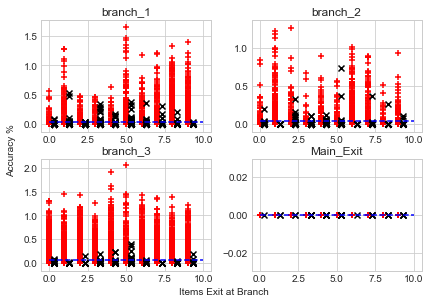

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,5000,0.7626,0.762600,0.045586,0.209600,1008,40,0.961832,0.961832,40,0,0
1,branch_2,3952,0.8154,0.778593,0.040220,0.170294,650,23,0.965825,0.967311,22,0,1
2,branch_3,3279,0.9558,0.936566,0.063176,0.669411,2181,14,0.993622,0.994989,11,0,3
3,Main_Exit,1084,0.9910,0.962177,0.000000,1.000000,1043,41,0.962177,inf,0,0,41


In [58]:
displayEvidence_cascade(validation_Outputs, Evidence = True)

mean 0.0071180407012081896  std 0.0417395117312799
rollover enabled, 7843 predictions provided
mean 0.003780258221507589  std 0.02761419295949236


c:\users\sanity\appdata\local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


rollover enabled, 6577 predictions provided
mean 0.022312147958141224  std 0.06906060695298791
rollover enabled, 2323 predictions provided
mean 0  std 0.0
threshold not supplied for branch 3, using test data


c:\users\sanity\appdata\local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:311: RuntimeWarning: divide by zero encountered in longlong_scalars


<Figure size 432x288 with 0 Axes>

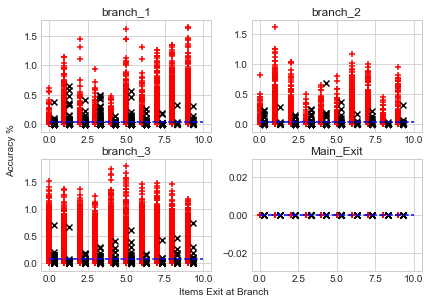

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,10000,0.7556,0.755600,0.045586,0.215700,2076,81,0.962448,0.968011,69,9,12
1,branch_2,7843,0.8119,0.771388,0.040220,0.161418,1224,42,0.966825,0.973934,33,6,9
2,branch_3,6577,0.9432,0.922001,0.063176,0.646799,4199,55,0.987071,0.993888,26,11,29
3,Main_Exit,2323,0.9643,0.879036,0.000000,1.000000,2042,281,0.879036,inf,0,0,281


In [59]:
displayEvidence_cascade(test_Outputs, thresholds=[0.045586,0.040220,0.063176],  Evidence = True)

In [ ]:
'''     overlap
        if zero, both match, if else they don't match
        TT 1-1 =0
        TF 1-0 =1

        FT 0-1 = -1
        FF 0-0 =0
        
        '''
# print(Outputs[1])
displayEvidence(Outputs, Evidence = True)

In [ ]:
### 227,227 sigmoid evidence cifar10 v2
# print(Outputs[0])

displayEvidence(Outputs, Evidence = False)

In [ ]:
### 227,227 sigmoid evidence cifar10
displayEvidence(Predictions)

In [ ]:
### 227,227 sigmoid cifar10
displayEvidence(Predictions)

In [ ]:
### 32,32 crossEvidence cifar10
displayEvidence(Predictions)

In [ ]:

displayEvidence(Predictions)

In [ ]:
displayEvidence(Predictions)


In [ ]:
model_2 = tf.keras.models.load_model('alexNetv6_evidence_test.hdf5',
    custom_objects={"CrossEntropyEndpoint":CrossEntropyEndpoint,"crossEntropy_loss":loss_function()})

In [ ]:
Predictions_2 = collectEvidence(model_2,test_ds)

In [ ]:
displayEvidence(Predictions_2)

In [ ]:
def collectEntropy(model,test_ds):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
#     print(item)

    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    Outputs = pd.DataFrame()
    output_names=["mainExit"]
    pAcc=[]
    for i, (x,y) in enumerate(test_ds):
#     for i in range(100):
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        result = model.predict(x)
        pClass.append(tf.argmax(y,1).numpy()[0])
        pred= (tf.nn.softmax(result)[0])

        pEvidence.append(calcEntropy_Tensors(pred).numpy())
        if np.argmax(pred) == np.argmax(y):
            pAcc.append(1)       
        else:
            pAcc.append(0)
    Predictions = pd.DataFrame({"label":pClass,"evidence":pEvidence,"Acc":pAcc,"overlap":0})
    return Predictions

def displayEntropy(Predictions):
    output_names=["mainExit"]
    Outputs=pd.DataFrame()
    Predictions["Acc"]=Predictions["Acc"].astype('bool')
    acc = Predictions["Acc"].value_counts()
    print(acc)
    print((acc.loc[True] , acc.loc[False]))
    mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
    std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]
    E_threshold = mean - std
    correct_rows = Predictions.loc[Predictions['Acc'] == True]
    incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
    # Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
    print(acc)
    for i,name in enumerate(output_names):
        Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                "E_Threshold":E_threshold,
                # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                "acceptance_rate":Predictions.loc[(Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] < E_threshold)].count()[0],
                # "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                # "Incorrects_overlap":Incorrects_overlap,
                },index=[i]))

    # fig, axs = plt.subplots(1, 2)
    plt.suptitle('Horizontally stacked subplots')
    plt.scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
    plt.scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
    plt.plot(np.repeat(E_threshold,11),'b--')
    plt.title("evidence")


    # fig.set_size_inches(10, 10)
    plt.show()
    return Outputs
    


In [ ]:
# Entropy_predictions = collectEntropy(model_2,test_ds)


In [ ]:
displayEntropy(Entropy_predictions)

In [ ]:

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
test_images = test_images.reshape(10000, 32,32,3).astype("float32") / 255

# print(y_train)
K= 10 # number of classes
test_labels = tf.keras.utils.to_categorical(test_labels,10)
shuffle_size = 22500
batch_size=1
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

def augment_images(image, label,input_size=(227,227), channel_first = False):
            image = tf.image.resize(image,input_size)
            if channel_first:
                image = tf.transpose(image, [2, 0, 1])
            return image, label
test_ds_size = len(list(test_ds))
# test_ds = (test_ds.map(augment_images))
t_target = tf.data.Dataset.from_tensor_slices((test_labels))
test_ds = tf.data.Dataset.zip((test_ds,t_target))
test_ds = (test_ds.batch(batch_size=1, drop_remainder=True))

In [ ]:
Predictions_mse = collectEvidence(model,test_ds)

In [ ]:
displayEvidence(Predictions_mse)

In [ ]:
#sum entropy 
import pandas as pd
def entropy(x):
    return -(x * math.log(x))
# Data for plotting
t = np.arange(0.00001, 1, 0.01)
print(t.shape)
t_ = np.full((100,), .1)
df = pd.DataFrame([t,t,t_,t,t])
# print(df.transpose())
p = df.apply(calcEntropy,axis=0)
# print(p)
# print(p)
fig, ax = plt.subplots()
ax.plot(t, p)
ax.set(xlabel='Probability of Outcome',ylabel='Entropy of event')

plt.show()


In [ ]:
y_true = [0]
y_pred = [.99,.01, .01, .0, .01, .01]
# Using 'auto'/'sum_over_batch_size' reduction type.  
scce = tf.keras.losses.SparseCategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossE: ",crossE)

In [ ]:
y_true = [0,1,0,0,0,0]
y_pred = [.99,.01, .01, .0, .01, .01]
# Using 'auto'/'sum_over_batch_size' reduction type.  
scce = tf.keras.losses.CategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossE: ",crossE)

In [ ]:
y_true = [0]
y_pred = [.0,.01, .9, .0, .0, .0]
ent = calcEntropy(y_pred)
print("Entropy: ",ent)
loss = ent *1
print("Loss: ",loss)

In [ ]:
y_true = [[0],[0],[0]]
y_pred = [[.9,.5, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]]
y_pred = [[.9,.0,.0,.0,.0,.0,],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]]
# y_pred = [.1,.1, .1, .1, .1, .1]
# Using 'auto'/'sum_over_batch_size' reduction type.  
scce = tf.keras.losses.SparseCategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossE: ",crossE)

''' When the answer is correct, CrossE goes down
    When 
    When its wrong, Entropy High
    When its right, Entropy Low
    
    so penalize being right with low entropy and reward being right with high entropy
    
    
    OORRRR train a second model for a branch to determine if you are going to get it right or not?
    Isn't that what ResNet Did? you calculate if the blocks will contribute, was it block drop?
    Binary classification,
    could be done at the branch end as a separate evaulator, using the entropy score and the input to the branch as inputs?
'''


ent = calcEntropy(y_pred)
print("Entropy: ",ent)
loss = crossE + ent
print("combined Loss: ",loss)

In [ ]:
x = [[.1,.1, .675, .1091, .4311, .1875,.121,.143,.2,.5]]
x = tf.constant([[2, 20, 30, 3, 6], [3, 11, 16, 1, 8],
                 [14, 45, 23, 5, 27]])

print(list(map(np.argmax,np.array(x))))
def foo(y_pred):
    y_pred = y_pred.numpy()
    pred_label = list(map(np.argmax,np.array(y_pred)))
    return pred_label
%timeit foo(x)

In [ ]:
y_true = tf.constant([[2],[2],[0]])
A = tf.constant([.1,.1, .675, .1091, .4311, .1875,.121,.143,.2,.5])
B = tf.constant([[2, 20, 30, 3, 6], [3, 11, 16, 1, 8],
                 [14, 45, 23, 5, 27]])

y_pred = tf.constant([[.9,.5, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]])

# new_list = new_list = [list(range(10)) for _ in range(10)]

print(tf.math.argmax(y_pred,1))
pred_labels = tf.math.argmax(y_pred,1)
print(tf.reshape(y_true,pred_labels.shape))
indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
indexes = tf.reshape(indexes,[-1])
# print(tf.gather(B,indexes))
CorrectE = tf.gather(y_pred,indexes)
print(CorrectE)
# print(calcEntropy(CorrectE[0]))


results = tf.map_fn(calcEntropy,tf.cast(CorrectE,'float'))
print("results: ",results)



%timeit tf.map_fn(calcEntropy,tf.cast(CorrectE,'float'))


crossE = tf.keras.losses.SparseCategoricalCrossentropy()
crossE(y_true,y_pred)
%timeit crossE(y_true,y_pred)
# [
#     [
#         [ 2 20 30  3  6]
#     ]
#     [
#         [ 3 11 16  1  8]
#     ]
# ]

def entropyAddition_noCross(y_true, y_pred):
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    #Entropy is added to the CrossE divided by the len of inputs
    pred_labels = tf.math.argmax(y_pred,1)
    indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
    indexes = tf.reshape(indexes,[-1])
    entropies = tf.gather(y_pred,indexes)
    if tf.equal(tf.size(entropies), 0):
        correctEntropies = 0
    else:
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy_Tensors,tf.cast(entropies,'float')))
    scce = crossE(y_true, y_pred)
    loss = correctEntropies
    return loss

In [ ]:
y_true = tf.constant([[1],[2],[0]])
y_pred = tf.constant([[0,0, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.9,.3, .3, .2, .1, .32]])
crossE = tf.keras.losses.SparseCategoricalCrossentropy()
def entropyAddition(y_true, y_pred):
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    #Entropy is added to the CrossE divided by the len of inputs
    pred_labels = tf.math.argmax(y_pred,1)
    indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
    indexes = tf.reshape(indexes,[-1])
    entropies = tf.gather(y_pred,indexes)
    if tf.equal(tf.size(entropies), 0):
        correctEntropies = 0
    else:
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy_Tensors,tf.cast(entropies,'float')))
    scce = crossE(y_true, y_pred)
    loss = scce + (correctEntropies * scce)
    return loss


print("normal CrossE: ",crossE(y_true ,y_pred))

print("normal Entropy",entropyAddition_noCross(y_true2,y_pred2))

print(entropyAddition(y_true2, y_pred2))
# %timeit entropyAddition(y_true, y_pred)

In [ ]:
y_true = tf.constant([1])
y_pred = tf.constant([0,1, 0, 0, 0, 0])
# print(crossE(y_true,y_pred))

print(tf.cast(1e-8,'float')+1)

In [ ]:
y_true = tf.constant([[1],[2],[0]])
y_pred = tf.constant([[.9,.1, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.9,.3, .3, .2, .1, .32]])
crossE = tf.keras.losses.SparseCategoricalCrossentropy()
def entropyMultiplication(y_true, y_pred):
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    #Entropy is added to the CrossE divided by the len of inputs
    pred_labels = tf.math.argmax(y_pred,1)
    indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
    indexes = tf.reshape(indexes,[-1])
    entropies = tf.gather(y_pred,indexes)
    if tf.equal(tf.size(entropies), 0):
        correctEntropies = 1
    else:
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy_Tensors,tf.cast(entropies,'float')))
    scce = crossE(y_true, y_pred)
    loss = correctEntropies * scce
    return loss


print("normal CrossE: ",crossE(y_true,y_pred))
print(entropyAddition(y_true, y_pred))
# %timeit entropyAddition(y_true, y_pred)

In [ ]:
y_true = tf.constant([[1],[2],[1]])
y_pred = tf.constant([[.9,.1, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.9,.3, .3, .2, .1, .32]])

def confidenceScore(y_true, y_pred):
        # print(y_pred)
        # print(tf.keras.backend.get_value(y_pred))
        
        # y_true =y_true.numpy()
        # y_pred = y_pred.numpy()
        # AvgConfidence = -1
        pred_labels = tf.math.argmax(y_pred,1)
        # countCorrect=0
        indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
        indexes = tf.reshape(indexes,[-1])
        entropies = tf.gather(y_pred,indexes)
        if tf.equal(tf.size(entropies), 0):
            correctEntropies = 0
        else:
            correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy,tf.cast(entropies,'float')))    
        
        return correctEntropies
    
print(confidenceScore(y_true,y_pred))

In [ ]:
y_true = [[2],[2],[0]]
y_pred = [[.9,0, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]]

def foo(x, y):
    scce = tf.keras.losses.SparseCategoricalCrossentropy()
    crossE = scce(x, y).numpy()
    return crossE

print(foo(y_true,y_pred))
%timeit foo(y_true,y_pred)

In [ ]:

# Python program explaining 
# where() function 
  
import numpy as np
  
# a is an array of integers.
a = np.array([[1, 2, 3], [4, 5, 6]])
  
print(a)
  
print ('Indices of elements <4')
  
b = np.where(a<5)
print(b)
  
print("Elements which are <4")
print(a[b])

In [ ]:
y_true = [[0],[0],[0]]
y_pred = [[.5,.5, .6, .5, .5, .1],[.5,.5, .6, .5, .5, .2],[.5,.5, .6, .5, .5, .3]]
# y_pred = [[1],[1],[1]]
# print(np.array(y_pred))

####
# Numpy confidence metric version
y_true =np.array(y_true)
y_pred = np.array(y_pred)
def argmax(x):
    return [np.argmax(x)]
pred_labels = list(map(argmax,np.array(y_pred)))
x = np.where(np.equal(y_true,pred_labels) ==True)
y = y_pred[x[0]]
results = calcEntropy(y)
print(results)
if not (results):
    print("A")
print(np.median(results))


In [ ]:
y_true = [[2],[2],[0]]
y_pred = [[.5,.5, .6, .5, .5, .5],[.5,.5, .6, .5, .5, .5],[.5,.5, .6, .5, .5, .5]]

y_true = [[2]]
y_pred = [[.1,.1, .15, .1, .1, .1]]
def entropyAddition_loss():
    #create a wrapper function that returns a function
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    def entropyAddition(y_true, y_pred):
        #Entropy is added to the CrossE divided by the len of inputs
        pred_labels = tf.math.argmax(y_pred,1)
        indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
        indexes = tf.reshape(indexes,[-1])
        entropies = tf.gather(y_pred,indexes)
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy,tf.cast(entropies,'float')))
#         print(pred_label)
        scce = crossE(y_true, y_pred)
        sumEntropy = 0
        loss = correctEntropies + scce
        return loss
    
    return entropyAddition

def custom_loss_multi(y_true, y_pred):
    #CrossE is multiplied by the Entropy
    pred_label = list(map(np.argmax,np.array(y_pred)))
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    sumLoss = 0
    
    for i in range(len(y_pred)):
        loss = crossE(y_true[i], y_pred[i])
#         print('crossE: ',loss)
        if pred_label[i] == y_true[i]:
#             print('calcEntropy ',calcEntropy(y_pred[i]))
            loss = loss * calcEntropy(y_pred[i])
        sumLoss += loss
    sumLoss = sumLoss / len(y_pred)         
    
#     loss = crossE(y_true, y_pred)
#     print("CrossE : ",loss.numpy())
#     print("Loss : ",sumLoss)
    return sumLoss
    ### I want to reduce the entropy of correct answers
    ### if label - pred = 0 (aka correct) then add entropy to crossE
    
    
#     squared_difference = tf.square(np.array(y_true) - np.array(y_pred))
#     return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

scce = tf.keras.losses.SparseCategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossEntropyLoss: ",crossE)


crossE = custom_loss_addition(y_true, y_pred).numpy()
print("customLoss_addition: ",crossE)


crossE = custom_loss_multi(y_true, y_pred).numpy()
print("customLoss_multi: ",crossE)

  
# model.compile(loss=custom_loss, optimizer='adam')



In [ ]:

def sub(x,y):
    if x - y == 0:
        return 1
%timeit sub(5,5)

In [ ]:

def sub(x,y):
    if x == y:
        return 0
    
%timeit sub(5,5)